In [1]:
import numpy as np
from scipy.stats import norm
from scipy.stats import kendalltau 
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from joblib import Parallel, delayed
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

def fit_xgb_model(x, y):
    model = XGBRegressor()
    model.fit(x, y)
    return model

def fit_rf_model(x, y):
    model = RandomForestRegressor()
    model.fit(x, y)
    return model

def generate_data(n, m):
    x = np.random.multivariate_normal(mean, cov, n)
    x_unlabel = np.random.multivariate_normal(mean, cov, m)
    x1 = norm.cdf(x[:, 0])
    x2 = norm.cdf(x[:, 1])
    v = norm.ppf(x1) + 0.05 * np.random.normal(0, 1, n)
    w = norm.ppf(x2) + 0.05 * np.random.normal(0, 1, n)
    return x, x_unlabel, v, w


# parameters
mean = (0, 0)
cov = [[1, 0], [0, 1]]
m = 50000

    
def run_experiment(seed, n):    
    x, x_unlabel, v, w = generate_data(n,m)
    
    # Split the data in half for training and testing
    n_half = n // 2
    m_half = m // 2
    
    x_a, x_b, v_a, v_b, w_a, w_b = (
        x[:n_half], x[n_half:], v[:n_half], v[n_half:], w[:n_half], w[n_half:]
    )
    x_unlabel_a, x_unlabel_b = (
        x_unlabel[:m_half], x_unlabel[m_half:]
    )
    
    orign, _ = kendalltau(v,w)
    
    # full
    ecdf_v_values = np.sum((v[:, None] <= v), axis=0) / len(v)
    ecdf_w_values = np.sum((w[:, None] <= w), axis=0) / len(w)
    ecdf_vw_values = np.sum((v[:, None] <= v) & (w[:, None] <= w), axis=0) / len(v)
    
    # split a
    ecdf_v_a_values = np.sum((v_a[:, None] <= v_a), axis=0) / len(v_a)
    ecdf_w_a_values = np.sum((w_a[:, None] <= w_a), axis=0) / len(w_a)
    ecdf_vw_a_values = np.sum((v_a[:, None] <= v_a) & (w_a[:, None] <= w_a), axis=0) / len(v_a)
    
    # split b
    ecdf_v_b_values = np.sum((v_b[:, None] <= v_b), axis=0) / len(v_b)
    ecdf_w_b_values = np.sum((w_b[:, None] <= w_b), axis=0) / len(w_b)
    ecdf_vw_b_values = np.sum((v_b[:, None] <= v_b) & (w_b[:, None] <= w_b), axis=0) / len(v_b)
    
    ell1 = (1 - 2 * ecdf_v_values) * (1 - 2 * ecdf_w_values) + 4 * (ecdf_vw_values - ecdf_v_values * ecdf_w_values)
    ell1_a = (1 - 2 * ecdf_v_a_values) * (1 - 2 * ecdf_w_a_values) + 4 * (ecdf_vw_a_values - ecdf_v_a_values * ecdf_w_a_values)
    ell1_b = (1 - 2 * ecdf_v_b_values) * (1 - 2 * ecdf_w_b_values) + 4 * (ecdf_vw_b_values - ecdf_v_b_values * ecdf_w_b_values)
    ell1_cross = np.concatenate((ell1_a, ell1_b)) 
    
    ## model 1
    # full
    model_full = fit_rf_model(x, ell1)
    fhat_label = model_full.predict(x)
    fhat_unlabel = model_full.predict(x_unlabel)
    
    # split a
    model_a = fit_rf_model(x_a, ell1_a)
    fhat_label_b = model_a.predict(x_b)
    fhat_unlabel_b = model_a.predict(x_unlabel_b)
    
    # split b
    model_b = fit_rf_model(x_b, ell1_b)
    fhat_label_a = model_b.predict(x_a)
    fhat_unlabel_a = model_b.predict(x_unlabel_a)
    
    fhat_label_cross = np.concatenate((fhat_label_a, fhat_label_b))
    fhat_label_unlabel_cross = np.concatenate((fhat_label_cross, fhat_unlabel_a, fhat_unlabel_b))
    
    # Semi-supervised Kendall tau
    kendall_SS_full = orign - 2 * np.mean(fhat_label) + 2 * np.mean(np.concatenate((fhat_label, fhat_unlabel)))
    kendall_SS_cross = orign - 2 * np.mean(fhat_label_cross) + 2 * np.mean(fhat_label_unlabel_cross)
    
    sig2_cross_null = 4 / 9 + 4 * m / (n+m) * (np.var(fhat_label_cross - ell1_cross) - 1 / 9) 
    sig2_full_null = 4 / 9 + 4 * m / (n+m) * (np.var(fhat_label - ell1) - 1 / 9) 
    
    
    result1 = np.sqrt(n) * orign / np.sqrt(4/9)
    result2 = np.sqrt(n) * kendall_SS_full / np.sqrt(sig2_full_null)
    result3 = np.sqrt(n) * kendall_SS_cross / np.sqrt(sig2_cross_null)
    
    
    ## model 2
    # full
    model_full = fit_xgb_model(x, ell1)
    fhat_label = model_full.predict(x)
    fhat_unlabel = model_full.predict(x_unlabel)
    
    # split a
    model_a = fit_xgb_model(x_a, ell1_a)
    fhat_label_b = model_a.predict(x_b)
    fhat_unlabel_b = model_a.predict(x_unlabel_b)
    
    # split b
    model_b = fit_xgb_model(x_b, ell1_b)
    fhat_label_a = model_b.predict(x_a)
    fhat_unlabel_a = model_b.predict(x_unlabel_a)
    
    fhat_label_cross = np.concatenate((fhat_label_a, fhat_label_b))
    fhat_label_unlabel_cross = np.concatenate((fhat_label_cross, fhat_unlabel_a, fhat_unlabel_b))
    
    # Semi-supervised Kendall tau
    kendall_SS_full = orign - 2 * np.mean(fhat_label) + 2 * np.mean(np.concatenate((fhat_label, fhat_unlabel)))
    kendall_SS_cross = orign - 2 * np.mean(fhat_label_cross) + 2 * np.mean(fhat_label_unlabel_cross)
    
    sig2_cross_null = 4 / 9 + 4 * m / (n+m) * (np.var(fhat_label_cross - ell1_cross) - 1 / 9) 
    sig2_full_null = 4 / 9 + 4 * m / (n+m) * (np.var(fhat_label - ell1) - 1 / 9) 
    
    result4 = np.sqrt(n) * kendall_SS_full / np.sqrt(sig2_full_null)
    result5 = np.sqrt(n) * kendall_SS_cross / np.sqrt(sig2_cross_null)

    return result1, result2, result3, result4, result5

# Create an array of rho values from 0 to 0.02
n_values = np.array((100,300,500,700,1000,1500,2000,3000,5000))

# Initialize empty lists to store the results for each rho value
result1_values = []
result2_values = []
result3_values = []
result4_values = []
result5_values = []

for n in tqdm(n_values):
    
    # Run the experiments and store the results for each rho
    num_iterations = 2000
    results = Parallel(n_jobs=-1)(delayed(run_experiment)(seed, n) for seed in range(num_iterations))
    results = np.array(results)
    
    # Calculate qnorm(0.95)
    qnorm_0975 = norm.ppf(0.975)
    
    # Calculate the power for each result
    power1 = np.mean(np.abs(results[:, 0]) > qnorm_0975)
    power2 = np.mean(np.abs(results[:, 1]) > qnorm_0975)
    power3 = np.mean(np.abs(results[:, 2]) > qnorm_0975)
    power4 = np.mean(np.abs(results[:, 3]) > qnorm_0975)
    power5 = np.mean(np.abs(results[:, 4]) > qnorm_0975)
    
    result1_values.append(power1)
    result2_values.append(power2)
    result3_values.append(power3)
    result4_values.append(power4)
    result5_values.append(power5)

 67%|█████████████████████████████▎              | 6/9 [11:08<06:18, 126.14s/it]/opt/anaconda3/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
100%|████████████████████████████████████████████| 9/9 [22:32<00:00, 150.27s/it]


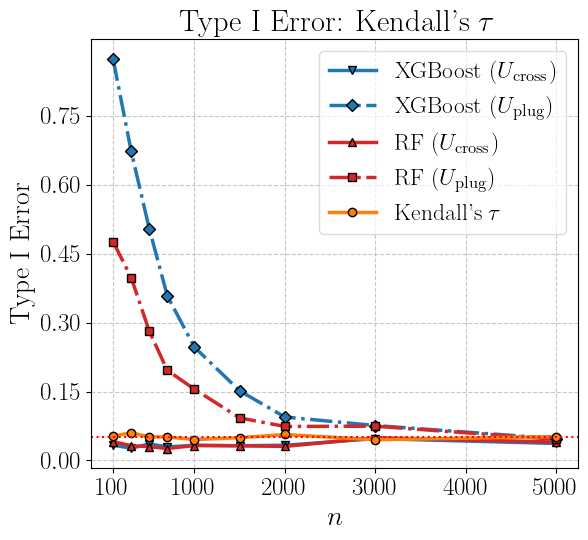

In [7]:
from matplotlib.ticker import FuncFormatter
custom_palette = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']


# Create the figure with a specific aspect ratio
plt.figure(figsize=(6, 5.5))

# Use consistent line styles and colors with markers
plt.plot(n_values, result5_values, label='XGBoost ($U_{\\mathrm{cross}}$)', linewidth=2.5, linestyle='-', color=custom_palette[0], marker='v', markeredgecolor='black')
plt.plot(n_values, result4_values, label='XGBoost ($U_{\\mathrm{plug}}$)', linewidth=2.5, linestyle='-.', color=custom_palette[0], marker='D', markeredgecolor='black')
plt.plot(n_values, result3_values, label='RF ($U_{\\mathrm{cross}}$)', linewidth=2.5, linestyle='-', color=custom_palette[3], marker='^', markeredgecolor='black')
plt.plot(n_values, result2_values, label='RF ($U_{\\mathrm{plug}}$)', linewidth=2.5, linestyle='-.', color=custom_palette[3], marker='s', markeredgecolor='black')
plt.plot(n_values, result1_values, label="Kendall's $\\tau$", linewidth=2.5, linestyle='-', color=custom_palette[1], marker='o', markeredgecolor='black')

plt.xlabel('$n$', fontsize=20)
plt.ylabel('Type I Error', fontsize=20)
plt.title("Type I Error: Kendall's $\\tau$", fontsize=22)  # Add a title


# Adjust the legend
legend = plt.legend(fontsize=17, loc='upper right')  # Add a title and adjust location
legend.get_title().set_fontsize(20)  # Increase the title fontsize
legend.get_frame().set_alpha(0.7)  # Make the legend background transparent
legend.get_frame().set_facecolor('white')  # Set a white background

# Set y-axis ticks starting at y=1 with appropriate increments
plt.axhline(y=0.05, color='red', linestyle=':', label='Baseline at y=1')
plt.yticks([0, 0.15, 0.3, 0.45, 0.60, 0.75], fontsize=18)
#plt.xticks([0, 0.0025, 0.005, 0.0075, 0.0100, 0.0125, 0.0150, 0.0175, 0.0200], fontsize=18)

# Define a custom x-axis tick formatter function
def custom_x_tick_formatter(x, pos):
    if x == 0:
        return '0'
    exp = int(np.floor(np.log10(abs(x))))
    mantissa = x / 10**exp
    if exp == 0:
        return f'{mantissa:.1f}'
    elif exp == -1:
        return f'${mantissa:.1f} \\cdot 10^{-1}$'
    else:
        return f'${mantissa:.1f} \\cdot 10^{exp}$'

# Apply the custom x-axis tick formatter
#formatter = FuncFormatter(custom_x_tick_formatter)
#plt.gca().xaxis.set_major_formatter(formatter)

plt.xticks([100,1000,2000,3000,4000,5000], fontsize=18)


# Use a professional LaTeX font style
plt.rc('text', usetex=True)
plt.rc('font', family='serif', serif='Computer Modern')

# Add gridlines for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# Save the figure in high-resolution (e.g., PDF) for the research paper
plt.tight_layout()
plt.savefig('kendal_type1.pdf', format='pdf', dpi=300)

plt.show()